In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt


In [2]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func


In [4]:
# Create engine using the `hawaii.sqlite` database file
engine = create_engine("sqlite:///Resources/hawaii.sqlite")


In [5]:
# Declare a Base using `automap_base()`
Base = automap_base()

# Use the Base class to reflect the database tables
Base.prepare(autoload_with=engine)

In [6]:
# Print all of the classes mapped to the Base
Base.classes.keys()

['station', 'measurement']

In [7]:
# Assign the measurement class to a variable called `Measurement` and
# assign the station class to a variable called `Station`
Measurement = Base.classes.measurement

In [8]:
# Create a session
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
# Find the most recent date in the data set.
session.query(Measurement.date).order_by(Measurement.date.desc()).first()

('2017-08-23',)

In [10]:
# EXTRA# query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
#print ("Query Date:", query_date)

Query Date: 2016-08-23


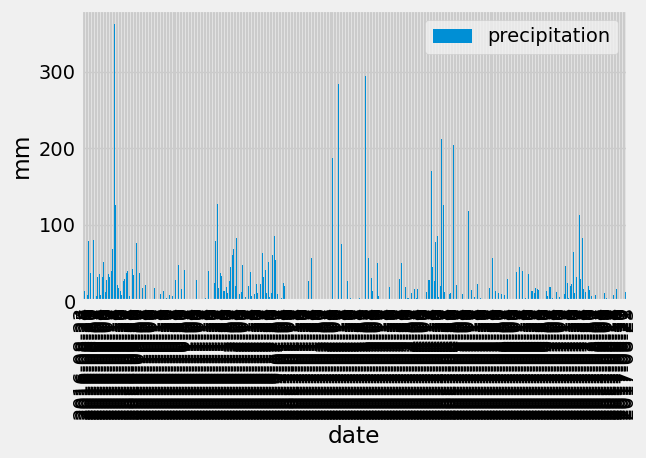

In [11]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results.
# Starting from the most recent data point in the database.
#  ExTRA precipitation = session.query(Measurement.date, Measurement.prcp).\
    #  ExTRA filter(Measurement.date >= query_date).all()

# Calculate the date one year from the last date in data set.
query_date = dt.date(2017, 8, 23) - dt.timedelta(days = 365)
print ("Query Date:", query_date)

# Perform a query to retrieve the data and precipitation scores
precipitation = session.query(Measurement.date, Measurement.prcp).\
    filter(Measurement.date >= query_date).all()

# Save the query results as a Pandas DataFrame. Explicitly set the column names
precipitation_df = pd.DataFrame(precipitation, columns=['date','precipitation'])
precipitation_df.count()

# Sort the dataframe by date
precipitation_df = precipitation_df.sort_values('date')
precipitation_df.head(50)

precipitation_groupby_obj = precipitation_df.groupby('date')

precipitation_series = precipitation_groupby_obj['precipitation'].sum()

precipitation_plot_df = pd.DataFrame(precipitation_series)
# precipitation_plot_df.head()

# Use Pandas Plotting with Matplotlib to plot the data
precipitation_plot_df.plot.bar()
precipitation_df.set_index('date', inplace=True)
plt.tight_layout()
plt.ylabel("mm")
plt.show()

In [12]:
# Use Pandas to calculate the summary statistics for the precipitation data
count = precipitation_df.count()
mean = precipitation_df['precipitation'].mean()
std = precipitation_df['precipitation'].std()
min = precipitation_df['precipitation'].min()
max = precipitation_df['precipitation'].max()

# Reference: https://www.aporia.com/blog/how-to/convert-index-dataframe-to-column/
quartiles = precipitation_df.quantile([.25, .5, .75])
quartiles = quartiles.reset_index().rename(columns={"index":"quartile"})
# Reference: https://stackoverflow.com/questions/36684013/extract-column-value-based-on-another-column-in-pandas
lowerq = quartiles.loc[quartiles['quartile'] == 0.25, 'precipitation'].iloc[0]
middleq = quartiles.loc[quartiles['quartile'] == 0.50, 'precipitation'].iloc[0]
upperq = quartiles.loc[quartiles['quartile'] == 0.75, 'precipitation'].iloc[0]

# Create a DataFrame for summary statistics
summary_statistics_df = pd.DataFrame({
    "count": count,
    "mean": mean,
    "std": std,
    "min": min,
    "25%": lowerq,
    "50%": middleq,
    "75%": upperq,   
    "max": max    
})

#Reference: https://www.geeksforgeeks.org/python-pandas-dataframe-transpose/
summary_statistics_df.transpose()

,precipitation
count,2021.000000
mean,4.505888
std,11.713487
min,0.000000
25%,0.000000
50%,0.500000
75%,3.300000
max,170.200000


# Exploratory Station Analysis

In [13]:
# Design a query to calculate the total number of stations in the dataset    # Answer = 9
station_count = session.query(Measurement).group_by(Measurement.station).count()
print(station_count)

9


In [14]:
# Design a query to find the most active stations (i.e. which stations have the most rows?) #.desc()
# List the stations and their counts in descending order.
# Reference: https://stackoverflow.com/questions/1052148/group-by-count-function-in-sqlalchemy
# Reference: https://stackoverflow.com/questions/4186062/sqlalchemy-order-by-descending
from sqlalchemy import desc

sel = [Measurement.station,
      func.count(Measurement.station)]
results = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(desc(func.count(Measurement.station))).all()
results

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [15]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [func.min(Measurement.tobs),
    func.max(Measurement.tobs),
    func.avg(Measurement.tobs)]
summary_stats1 = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    order_by(Measurement.station).all()
summary_stats1

[(12.2, 29.4, 22.03582251082252)]

In [16]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
from sqlalchemy import asc

sel = [Measurement.tobs,
      func.count(Measurement.tobs)]
temp_frequency = session.query(*sel).\
    filter(Measurement.station == 'USC00519281').\
    filter(Measurement.date >= query_date).\
    group_by(Measurement.tobs).\
    order_by(asc(Measurement.tobs)).all()
temp_frequency

[(15.0, 3),
 (15.6, 2),
 (16.1, 1),
 (16.7, 6),
 (17.2, 4),
 (17.8, 3),
 (18.3, 7),
 (18.9, 5),
 (19.4, 15),
 (20.0, 12),
 (20.6, 19),
 (21.1, 22),
 (21.7, 18),
 (22.2, 22),
 (22.8, 18),
 (23.3, 39),
 (23.9, 33),
 (24.4, 33),
 (25.0, 31),
 (25.6, 22),
 (26.1, 18),
 (26.7, 11),
 (27.2, 4),
 (27.8, 3),
 (28.3, 1)]

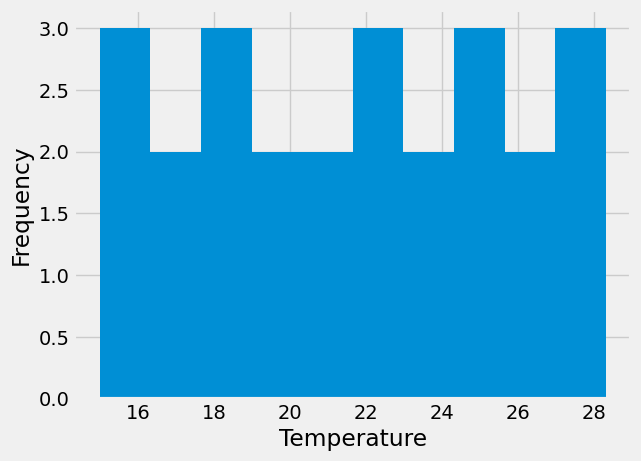

In [34]:
tobs_df = pd.DataFrame(temp_frequency, columns=['temperature','frequency'])
#tobs_df.head()

# Reference: https://matplotlib.org/stable/gallery/statistics/histogram_histtypes.html#sphx-glr-gallery-statistics-histogram-histtypes-py
plt.hist(tobs_df['temperature'])
#tobs_df.set_index('date', inplace=True)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [16]:
# Close Session
session.close()
